# Hyperparameter Tunning

* https://cloud.google.com/ai-platform/training/docs/hyperparameter-tuning-overview
* https://github.com/GoogleCloudPlatform/cloudml-hypertune
* https://optuna.org/

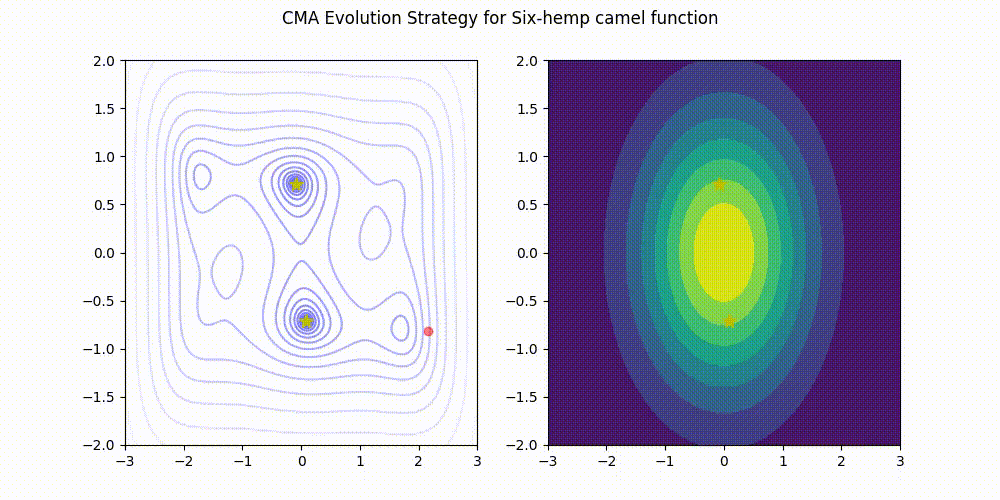

In [2]:
from IPython.display import Image
Image("https://optuna.org/assets/img/blog-cma-es.gif")

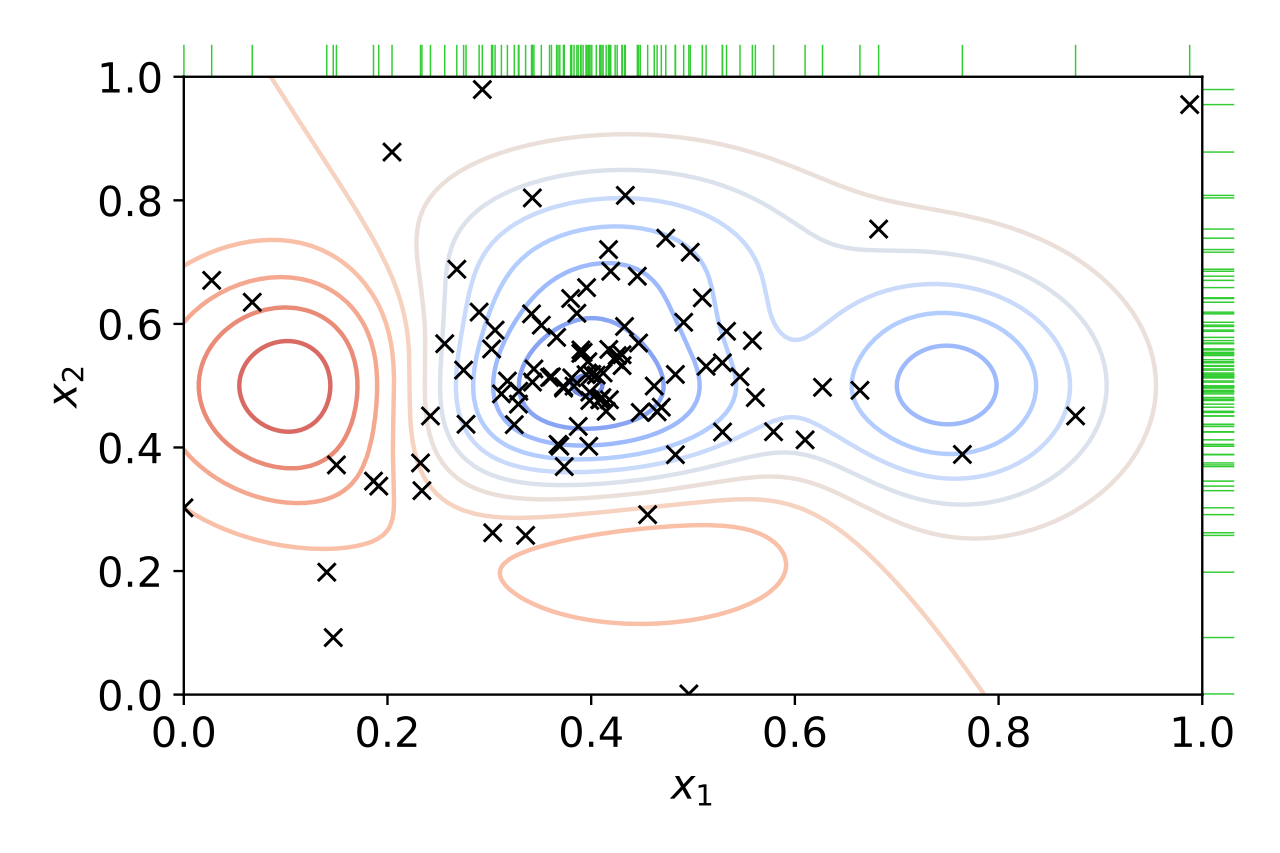

In [3]:
Image("imagenes/HPO.png")

In [ ]:
https://laurencemoroney.com/datasets.html

In [ ]:
FROM gcr.io/deeplearning-platform-release/tf2-gpu.2-5

WORKDIR /

# Installs hypertune library
RUN pip install cloudml-hypertune

# Copies the trainer code to the docker image.
COPY trainer /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.train"]

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import argparse
import hypertune #En el dockerfile tenemos el pip install

La función get_args devuelve los parametros que van a ser afinados (tune). En este caso será el 
* Learning rate. learning_rate
* Momento del algoritmo SGD. momentum
* Número de neuronas de la última capa oculta. num_neurons

In [ ]:
def get_args():
    '''Parses args. Must include all hyperparameters you want to tune.'''
    parser = argparse.ArgumentParser()
    parser.add_argument(
      '--learning_rate',
      required=True,
      type=float,
      help='learning rate')
    parser.add_argument(
      '--momentum',
      required=True,
      type=float,
      help='SGD momentum value')
    parser.add_argument(
      '--num_neurons',
      required=True,
      type=int,
      help='number of units in last hidden layer')
    args = parser.parse_args()
    return args

In [ ]:
def preprocess_data(image, label):
  '''Resizes and scales images.'''

  image = tf.image.resize(image, (150,150))
  return tf.cast(image, tf.float32) / 255., label


def create_dataset():
  '''Loads Horses Or Humans dataset and preprocesses data.'''

  data, info = tfds.load(name='horses_or_humans', as_supervised=True, with_info=True)

  # Create train dataset
  train_data = data['train'].map(preprocess_data)
  train_data  = train_data.shuffle(1000)
  train_data  = train_data.batch(64)

  # Create validation dataset
  validation_data = data['test'].map(preprocess_data)
  validation_data  = validation_data.batch(64)

  return train_data, validation_data

In [ ]:
def create_model(num_neurons, learning_rate, momentum):
    '''Defines and complies model.'''

    inputs = tf.keras.Input(shape=(150, 150, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(num_neurons, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
      metrics=['accuracy'])
    return model


def main():
    args = get_args()
    train_data, validation_data = create_dataset()
    model = create_model(args.num_neurons, args.learning_rate, args.momentum)
    history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=validation_data)

    # Definimos la métrica que queremos observar
    hp_metric = history.history['val_accuracy'][-1]
    # Podriamos definir una a minimizar
    # hp_metric = history.history['val_loss'][-1]

    hpt = hypertune.HyperTune()
    hpt.report_hyperparameter_tuning_metric(
      hyperparameter_metric_tag='accuracy',
      metric_value=hp_metric,
      global_step=NUM_EPOCHS)

In [ ]:
PROJECT_ID=''
IMAGE_URI="gcr.io/$PROJECT_ID/horse-human:hypertune"
docker build ./ -t $IMAGE_URI
docker push $IMAGE_URI # Lo llevamos al Google Container Registry